In [1]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image, ImageDraw, ImageFont
import cv2
import torch
from vit_captioning_analysis import VITCaptioningModel
from vit_captioning_analysis import display_att_map, find_mask_tokens

In [2]:
model = VITCaptioningModel(output_encoder_attentions=True, output_encoder_hidden_states=True)

model running on cuda


/home/braian/anaconda3/envs/thesis-pytorch/lib/python3.9/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


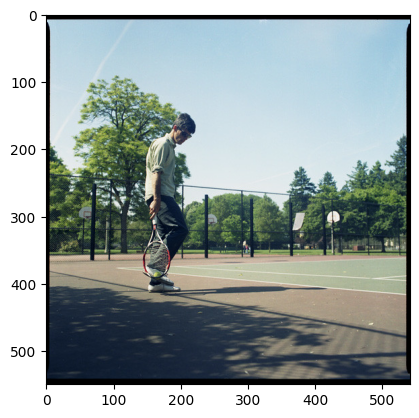

In [3]:
sample_image = Image.open('./526736409_b5dff13989_z.jpg').convert(mode="RGB")
plt.imshow(sample_image)

In [4]:
outputs = model.forward_pass([sample_image])
attention_maps = model.get_all_attention_maps(torch.stack(outputs.encoder_attentions))

In [5]:
attention_maps.shape

torch.Size([12, 1, 197, 197])

In [6]:
outputs.keys()

odict_keys(['loss', 'logits', 'past_key_values', 'encoder_last_hidden_state', 'encoder_hidden_states', 'encoder_attentions'])

### Sanity check

In [7]:
layer_n = 1

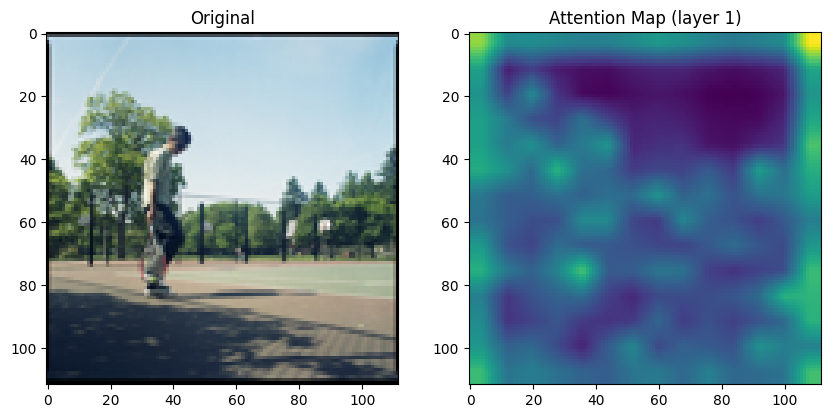

torch.Size([1, 197, 197])


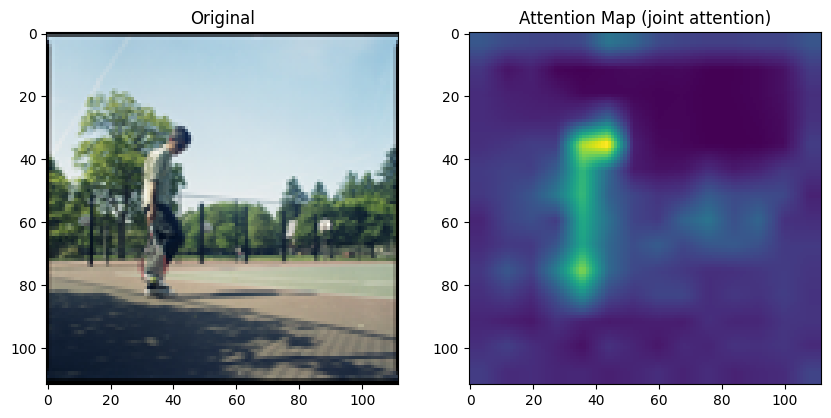

In [8]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 10))

ax1.set_title('Original')
ax2.set_title(f'Attention Map (layer {layer_n})')
_ = ax1.imshow(sample_image.resize((112,112)))
_ = ax2.imshow(display_att_map(attention_maps[layer_n][0], img_size = (112,112)))

plt.show()

joint_attention_layer = model.get_joint_attention_map(torch.stack(outputs.encoder_attentions))
print(joint_attention_layer.shape)

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 10))

ax1.set_title('Original')
ax2.set_title('Attention Map (joint attention)')
_ = ax1.imshow(sample_image.resize((112,112)))
_ = ax2.imshow(display_att_map(joint_attention_layer[0], img_size = (112,112)))


## Analyze images segmentation GT and attention maps

* each image has a set of `N` objects occurring `i` times
* for each object instance I can check foreground x background analysis and show stats

In [9]:
import json
import os
import pickle
import copy
from tqdm import tqdm
#load annotations
COCO_PATH = "../../../datasets/coco"
grid_size = 14

data_split = "train2017"
    
with open(os.path.join(COCO_PATH, f"annotations/instances_{data_split}.json"), 'r') as f:
    coco_segmentation = json.load(f)    
    
with open(os.path.join(COCO_PATH, f"annotations/captions_{data_split}.json"), 'r') as f:
    coco_captions = json.load(f)
    
with open('../coco_category_id_map.pickle', 'rb') as handle:
    category_id_map = pickle.load(handle)    

In [10]:
def add_segmentation(img: Image, annotation, fill="#eeeeff", outline='red'):
    img_draw = ImageDraw.Draw(img)  
    for segm in annotation['segmentation']:
        try:
            if isinstance(segm, list):
                img_draw.polygon(segm, fill=fill, outline=outline)
        except:
            print(segm)
            return img
    return img

def add_annotations(img: Image, annotations: list, skip_objects=[], font_size=10):
    #try to avoid writing on the same place
    coord_history = [[0,0]]
    texts = []
    font = ImageFont.truetype("/usr/share/fonts/truetype/ubuntu/Ubuntu-B.ttf", font_size)
    for ann in annotations:
        if isinstance(ann['segmentation'], list) and not ann["id"] in skip_objects:
            seg = ann['segmentation'][0]
            poly = Image.new('RGBA', img.size)
            img_draw = ImageDraw.Draw(poly) 
            color = (int(255*ann['att_score']),0,0,150) #(255,0,255,150)
            img_draw.polygon(ann['segmentation'][0],fill=color, outline=(0,0,0,255))    
            poly_center = get_bbox_center(ann)            
            if "label" in list(ann.keys()):
                distances = [(coord, np.linalg.norm(poly_center - coord)) for coord in coord_history if np.linalg.norm(poly_center - coord)<50]
                color = "white"
                if distances:
                    poly_center[1] -= np.random.randint(15, 40)
                coord_history.append(copy.deepcopy(poly_center))  
                texts.append((copy.deepcopy(poly_center), ann["label"], color))
            img.paste(poly,mask=poly)
    # avoid overlapping with masks
    for coord, text, color in texts:
        img_draw.text(coord, text, fill = color, font = font, align ="right", anchor="lt") 
        img.paste(poly, mask=poly)
        
    return img

def create_fg_mask(img_size, annotation) -> Image:
    pil_mask = np.zeros(shape=img_size, dtype=np.uint8)
    pil_mask = Image.fromarray(np.moveaxis(pil_mask, 0, -1))
    img_draw = ImageDraw.Draw(pil_mask) 
    
    for segm in annotation['segmentation']:
        if isinstance(segm, list):
            img_draw.polygon(segm, fill ="#ffffff")
    
    return pil_mask

def pre_process_mask(mask: Image, new_size=(224,224))-> np.ndarray:    
    fg_mask_img = copy.deepcopy(np.array(mask.resize(new_size)))
    # make it binary 255/0
#     fg_mask_img[fg_mask_img==255] = 255
    fg_mask_img[fg_mask_img!=255] = 0
    fg_mask_img = fg_mask_img[:,:,np.newaxis]
    
    return fg_mask_img

In [12]:
# Load specific preprocessed files
with open('../filtered_datasets/train2017/task1_person_accessory_data.json', "r") as f:
    task1_data = json.load(f)

In [86]:
sample_ann = task1_data['28'][3]
object_annotations = [ann for ann in sample_ann['annotations']['annotations'] if ann['iscrowd']==0]
object_annotations = sorted(object_annotations, key=lambda x:x["area"])
distinct_obj = len(object_annotations)
distinct_obj

6

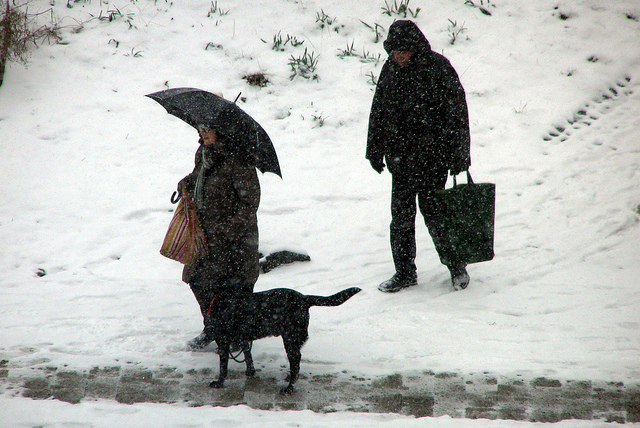

In [87]:
sample_img = Image.open(os.path.join(COCO_PATH, 'train2017', sample_ann['image']['file_name'])).convert('RGB')    
sample_img

In [88]:
outputs = model.forward_pass([sample_img])
attention_maps = model.get_all_attention_maps(torch.stack(outputs.encoder_attentions))

In [89]:
for layer in range(12):    
    disp_att_map = display_att_map(attention_maps[layer][0], img_size = (224, 224))
    print(layer, np.min(disp_att_map), np.max(disp_att_map))

0 0.36095944 0.98946446
1 0.15377848 1.0
2 0.12873796 0.9902918
3 0.045301992 0.98589885
4 0.043203004 0.9719504
5 0.037817627 0.9484144
6 0.0072013102 0.94066346
7 0.0010202132 0.9399327
8 0.00046045432 0.93987453
9 0.00066398433 0.9395988
10 0.0005342488 0.9677806
11 1.6544085e-05 0.9581935


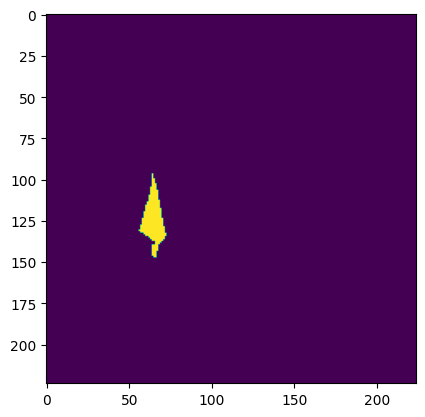

In [90]:
sample_mask = create_fg_mask(sample_img.size, object_annotations[0])
sample_mask = pre_process_mask(sample_mask)
plt.imshow(sample_mask)

In [91]:
mask_patches = find_mask_tokens(np.array(sample_img.resize((224,224))), sample_mask, .0)[1]
mask_patches

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False,  True,  True, False,
       False, False, False, False, False, False, False, False, False,
       False, False,  True,  True, False, False, False, False, False,
       False, False, False, False, False, False, False,  True,  True,
       False, False, False, False, False, False, False, False, False,
       False, False,

0.0 0.63933027


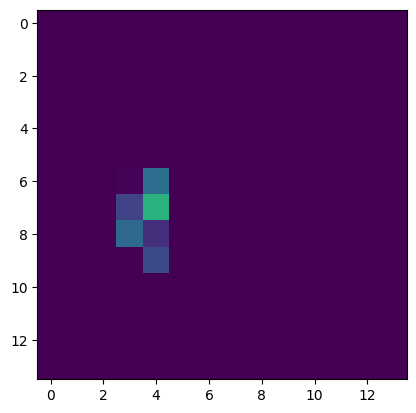

In [92]:
layer = 11

overlaid_att_map = attention_maps[layer][0][0, 1:]
# put into [0,1] scale
overlaid_att_map = overlaid_att_map / overlaid_att_map.max()
overlaid_att_map[~mask_patches] = 0.0
overlaid_att_map = overlaid_att_map.reshape(grid_size, grid_size).cpu().detach().numpy()
# overlaid_att_map = cv2.resize(overlaid_att_map, (224, 224))
print(np.min(overlaid_att_map), np.max(overlaid_att_map))
plt.imshow(overlaid_att_map, vmin=0.0, vmax=1.0)

In [93]:
def order_objects_by_attention(seg_annotations, img, attention_maps):
    chosen_tokens = np.zeros(shape=(196), dtype="bool")
    object_attn_rank = []
    for segmentation in seg_annotations:
        fgmask = create_fg_mask(img.size, segmentation)
        fgmask = pre_process_mask(fgmask)   
    #     plt.imshow(sample_mask)
    #     plt.show()

        mask_patches = find_mask_tokens(np.array(img.resize((224,224))), fgmask, .0)[1]

        overlaid_att_map = attention_maps
        # put into [0,1] scale
        overlaid_att_map = overlaid_att_map / overlaid_att_map.max()
        overlaid_att_map[~mask_patches] = 0.0
        overlaid_att_map[chosen_tokens] = 0.0
#         overlaid_att_map = overlaid_att_map.reshape(grid_size, grid_size)
        # overlaid_att_map = cv2.resize(overlaid_att_map, (224, 224))
    #     plt.imshow(overlaid_att_map, vmin=0.0, vmax=1.0)
    #     plt.title(f"max attention {category_id_map[segmentation['category_id']]} token {np.argmax(overlaid_att_map)} {np.max(overlaid_att_map)}")
    #     plt.show()
        object_attn_rank.append((segmentation['id'], np.argmax(overlaid_att_map), np.max(overlaid_att_map)))
#         print(f"chosen token {np.argmax(overlaid_att_map)}")
        chosen_tokens[np.argmax(overlaid_att_map)] = True
    return object_attn_rank

In [95]:
# do the same as above but for all objects
layer = 4
attention_obj_layer = []
for layer in range(12):
    rank = order_objects_by_attention(object_annotations, sample_img, attention_maps[layer][0][0, 1:].cpu().detach().numpy())    
    attention_obj_layer.append(sorted(rank, key=lambda x: x[2]))    
attention_obj_layer

[[(285453, 61, 0.7297529),
  (227564, 131, 0.754815),
  (12781, 144, 0.77000135),
  (1172400, 130, 0.8450844),
  (1175521, 93, 0.85752285),
  (235218, 8, 0.94793695)],
 [(285453, 61, 0.5234577),
  (1172400, 87, 0.59513915),
  (227564, 74, 0.5994602),
  (12781, 145, 0.6385855),
  (1175521, 80, 0.6435389),
  (235218, 8, 0.77042204)],
 [(1175521, 121, 0.60351783),
  (285453, 46, 0.73144466),
  (235218, 134, 0.7487971),
  (12781, 145, 0.7608153),
  (227564, 102, 0.96959877),
  (1172400, 116, 1.0)],
 [(1175521, 93, 0.4140402),
  (235218, 51, 0.4940705),
  (285453, 46, 0.5042406),
  (12781, 116, 0.6981906),
  (227564, 101, 0.8552038),
  (1172400, 102, 1.0)],
 [(1175521, 108, 0.4759356),
  (12781, 116, 0.5003557),
  (235218, 51, 0.5144465),
  (227564, 102, 0.63743806),
  (285453, 46, 0.7263951),
  (1172400, 101, 1.0)],
 [(1175521, 94, 0.2784573),
  (235218, 65, 0.3156443),
  (12781, 133, 0.33814353),
  (285453, 46, 0.36110783),
  (227564, 101, 0.3828365),
  (1172400, 102, 0.3847)],
 [(1175521

In [96]:
# Do it sequentially for images in a proccessed dataset

  0%|                                                                                             | 0/1 [00:00<?, ?it/s]Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.
/home/braian/anaconda3/envs/thesis-pytorch/lib/python3.9/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(
/home/braian/anaconda3/envs/thesis-pytorch/lib/python3.9/site-packages/transformers/generation/utils.py:1288: UserWarning: Using `max_length`'s default (20) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


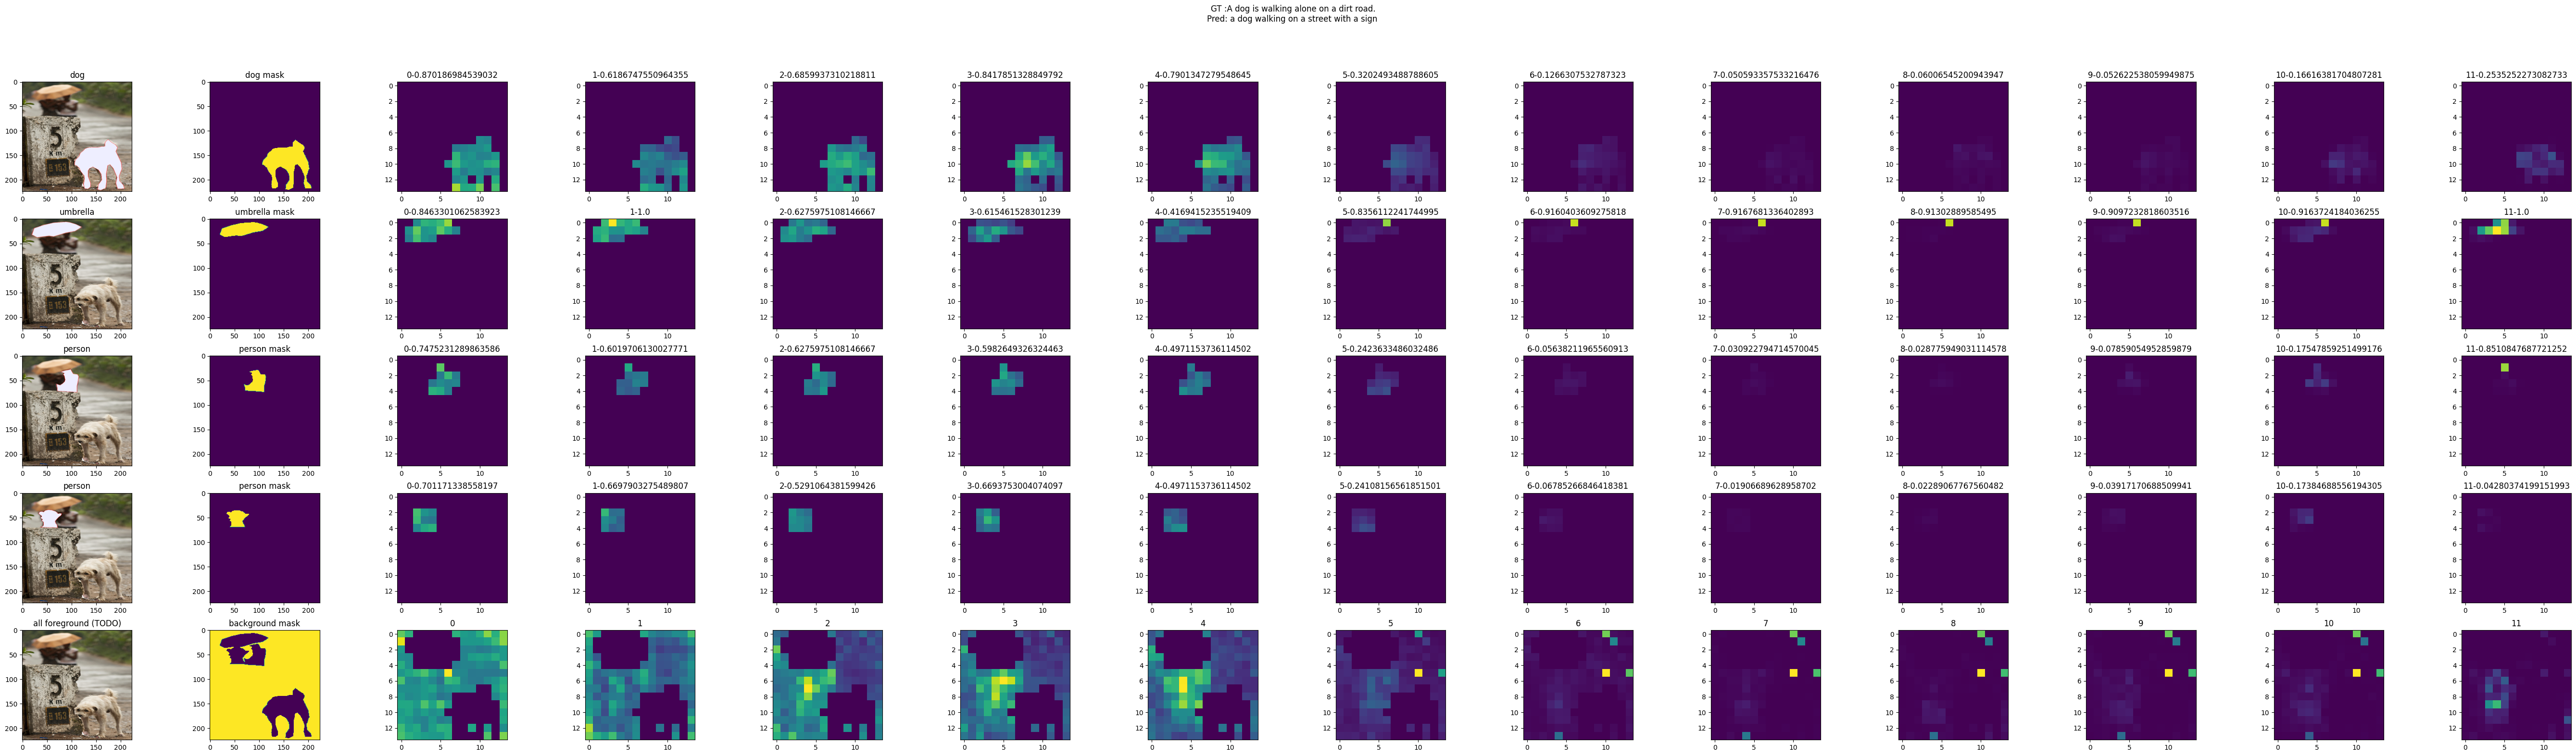

100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:16<00:00, 16.90s/it]


In [97]:
for sample_ann in tqdm(task1_data['28'][:1]):
    sample_img = Image.open(os.path.join(COCO_PATH, 'train2017', sample_ann['image']['file_name'])).convert('RGB')    

    object_annotations = [ann for ann in sample_ann['annotations']['annotations'] if ann['iscrowd']==0]
    distinct_obj = len(object_annotations)
    
    fig, axs = plt.subplots(nrows=distinct_obj+1, ncols=14, figsize=(55, 4*distinct_obj))
    gt_caption = sample_ann['annotations']['caption']
    pred_caption = model.generate_caption(sample_img)[0]['generated_text']
    fig.suptitle(f"GT :{gt_caption}\nPred: {pred_caption}")

    outputs = model.forward_pass([sample_img])
    attention_maps = model.get_all_attention_maps(torch.stack(outputs.encoder_attentions))
    resized_img = np.array(sample_img.resize((224,224)))

    all_fg_mask = np.zeros(shape=sample_img.size, dtype=np.uint8)
    all_fg_mask = Image.fromarray(np.moveaxis(all_fg_mask, 0, -1))

    for idx, ann in enumerate(object_annotations):
        axs[idx, 0].set_title(f"{category_id_map[ann['category_id']]}")
        axs[idx, 0].imshow(add_segmentation(copy.deepcopy(sample_img), ann).resize((224,224)))    

        mask = create_fg_mask(sample_img.size, ann)
        mask = pre_process_mask(mask)
        axs[idx, 1].set_title(f"{category_id_map[ann['category_id']]} mask")
        axs[idx, 1].imshow(mask, vmin=0, vmax=255)

        mask_patches = find_mask_tokens(resized_img, mask, .05)[1]    

        # add annotation to the empty all_fg_mask. 
        # in the end reverting it results in the bg_mask
        add_segmentation(all_fg_mask, ann, fill="#ffffff", outline="#ffffff")

        for layer in range(12):    
            overlaid_att_map = attention_maps[layer][0][0, 1:]
            # put into [0, 1] scale
            overlaid_att_map = overlaid_att_map / overlaid_att_map.max()
            overlaid_att_map[~mask_patches] = 0.0
            max_attention = np.max(overlaid_att_map.cpu().detach().numpy())
            overlaid_att_map = overlaid_att_map.reshape(grid_size, grid_size).cpu().detach().numpy()
            axs[idx, layer+2].set_title(f"{layer}-{max_attention}")
            axs[idx, layer+2].imshow(overlaid_att_map, vmin=0.0, vmax=1.0)

    axs[idx+1, 0].set_title("all foreground (TODO)")
    axs[idx+1, 0].imshow(resized_img)

    # get background mask by reversing the image mask
    all_fg_mask = pre_process_mask(all_fg_mask)
    bg_mask_img = copy.deepcopy(all_fg_mask)
    bg_mask_img[all_fg_mask==255] = 0
    bg_mask_img[all_fg_mask!=255] = 255
    axs[idx+1, 1].set_title("background mask")
    axs[idx+1, 1].imshow(bg_mask_img, vmin=0, vmax=255)

    mask_patches = find_mask_tokens(resized_img, bg_mask_img, .95)[1]    

    for layer in range(12):    
        overlaid_att_map = attention_maps[layer][0][0, 1:]
        # put into [0, 1] scale
        overlaid_att_map = overlaid_att_map / overlaid_att_map.max()
        overlaid_att_map[~mask_patches] = 0.0
        overlaid_att_map = overlaid_att_map.reshape(grid_size, grid_size).cpu().detach().numpy()
        axs[idx+1, layer+2].set_title(f"{layer}")
        axs[idx+1, layer+2].imshow(overlaid_att_map, vmin=0.0, vmax=1.0)

    fig.tight_layout()
    fig.subplots_adjust(top=0.88)
    plt.show()
#     plt.savefig(fname=f"layer_analysis_output_2/{pred_caption}.png")
    plt.close('all')

In [39]:
def order_obj_instances(img: Image, category_id:int, image_annotations, layer_attention_map):
    obj_instance_attention = {}
    
    object_annotations = [ann for ann in image_annotations['annotations']['annotations'] if ann['iscrowd']==0 and ann['category_id']==category_id]
    no_instances = len(object_annotations)
    for idx, ann in enumerate(object_annotations):
        mask = create_fg_mask(img.size, ann)
        mask = pre_process_mask(mask)
        mask_patches = find_mask_tokens(np.array(img.resize((224,224))), mask, .05)[1]
        
        obj_att_map = copy.deepcopy(layer_attention_map)
        # put into [0, 1] scale
        obj_att_map = obj_att_map / obj_att_map.max()
        # mask background
        obj_att_map[~mask_patches] = 0.0        
        max_attention = np.max(obj_att_map)        
        obj_instance_attention[idx] = max_attention
    
    obj_instance_sorted = sorted(obj_instance_attention.items(), key=lambda x:x[1], reverse=True)
    obj_instance_sorted = [(object_annotations[inst[0]],inst[1]) for inst in obj_instance_sorted]
    return obj_instance_sorted       
        

In [40]:
obj_list = order_obj_instances(sample_img, 28, sample_ann, attention_maps[0][0, 1:].cpu().detach().numpy())

In [43]:
[obj for obj in obj_list]

[({'segmentation': [[110.73,
     103.81,
     95.76,
     99.05,
     52.9,
     108.57,
     34.53,
     92.92,
     42.7,
     55.51,
     74.67,
     37.82,
     108.69,
     24.89,
     120.93,
     22.85,
     155.63,
     18.09,
     167.19,
     21.49,
     188.96,
     31.02,
     209.37,
     48.7,
     198.49,
     60.95,
     186.92,
     72.51,
     152.91,
     82.04,
     110.05,
     103.13]],
   'area': 9931.62985,
   'iscrowd': 0,
   'image_id': 32054,
   'bbox': [34.53, 18.09, 174.84, 90.48],
   'category_id': 28,
   'id': 286152},
  0.99770737)]

## Batch process dataset to add attentions

In [44]:
dataset_name = '../filtered_datasets/train2017/task4_dining_table_data.json'
with open(dataset_name, "r") as f:
    task1_data = json.load(f)

In [ ]:
layer = 11
for second_class, task_annotations in task1_data.items(): 
    print(f"class {second_class}")
    for idx, annotations in enumerate(tqdm(task_annotations)):
        object_annotations = [ann for ann in annotations['annotations']['annotations'] if ann['iscrowd']==0]
        object_annotations = sorted(object_annotations, key=lambda x:x["area"])

        img = Image.open(os.path.join(COCO_PATH, 'train2017', annotations["image"]["file_name"])).convert("RGB")
        outputs = model.forward_pass([img])
        attention_maps = model.get_all_attention_maps(torch.stack(outputs.encoder_attentions))
        rank = order_objects_by_attention(object_annotations, img, attention_maps[layer][0][0, 1:].cpu().detach().numpy())    
        for obj in object_annotations:
            ranked_obj = [(token, attn) for obj_id, token, attn in rank if obj_id == obj["id"]][0]
            obj["attentions"] = {"layer": layer , "token": int(ranked_obj[0]), "max_attention": float(ranked_obj[1])}

In [15]:
# save processed dataset in a json file
with open(dataset_name, "w") as f:
    json.dump(task1_data, f)

### Investigate difference in attention maps between Standard ViT and Captioning model

In [46]:
# Load specific preprocessed files
with open('../filtered_datasets/train2017/task1_person_accessory_data.json', "r") as f:
    task1_data = json.load(f)
    
# with open('../filtered_datasets/train2017/task2_diningtable_objects_data.json', "r") as f:
#     task2_data = json.load(f)    

In [47]:
## manually create an annotations to investigate
captions = [ann["caption"] for ann in coco_captions['annotations'] if ann["image_id"] == 4731]
selected_ann = {"annotations":
                    {"annotations": [ann for ann in coco_segmentation["annotations"] if ann["image_id"] == 4731],
#                         {"annotations": [ann for ann in coco_segmentation["annotations"] if ann["image_id"] == 4731]},
                    "captions": captions,
                    },
                "image": [ann for ann in coco_segmentation["images"] if ann["id"] == 4731][0]
               }
selected_ann["image"]

{'license': 2,
 'file_name': '000000004731.jpg',
 'coco_url': 'http://images.cocodataset.org/train2017/000000004731.jpg',
 'height': 425,
 'width': 640,
 'date_captured': '2013-11-14 22:47:52',
 'flickr_url': 'http://farm8.staticflickr.com/7049/6935101395_09e1824900_z.jpg',
 'id': 4731}

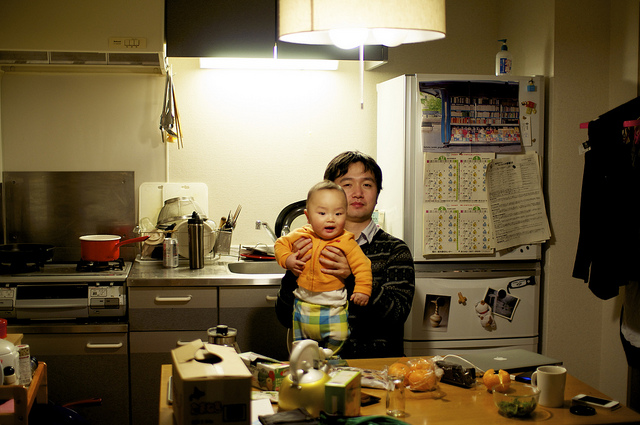

In [48]:
sample_ann = selected_ann 
sample_img = Image.open(os.path.join(COCO_PATH, 'train2017', sample_ann['image']['file_name'])).convert('RGB')    
sample_img

GT caption  : ['A man holding a baby up in a kitchen.', 'a man is holding up a baby while he is in the kitchen', 'A person holding a baby while standing in a kitchen.', 'A broad panorama of several people getting together.\n', 'There is a man holding up a baby in the kitchen.']


Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.
/home/braian/anaconda3/envs/thesis-pytorch/lib/python3.9/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(
/home/braian/anaconda3/envs/thesis-pytorch/lib/python3.9/site-packages/transformers/generation/utils.py:1288: UserWarning: Using `max_length`'s default (20) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Pred caption: a man holding a baby in a kitchen 


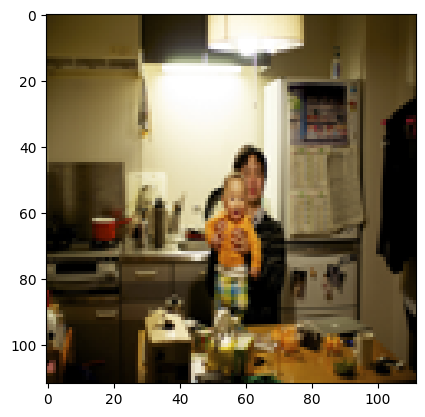

In [49]:
print(f"GT caption  : {sample_ann['annotations']['captions']}")
print(f"Pred caption: {model.generate_caption(sample_img)[0]['generated_text']}")
plt.imshow(sample_img.resize((112,112)))

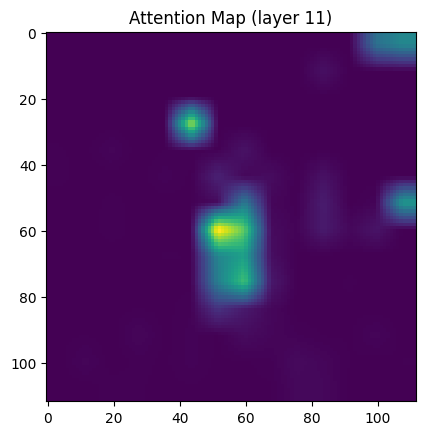

In [50]:
outputs = model.forward_pass([sample_img])
attention_maps = model.get_all_attention_maps(torch.stack(outputs.encoder_attentions))
plt.title(f'Attention Map (layer {11})')
plt.imshow(display_att_map(attention_maps[11][0], img_size = (112,112)))
plt.show()

In [51]:
## STANDARD ViT
from models.modeling import VisionTransformer, CONFIGS
from urllib.request import urlretrieve
from torchvision import transforms, datasets

In [52]:
os.makedirs("attention_data", exist_ok=True)
if not os.path.isfile("attention_data/ilsvrc2012_wordnet_lemmas.txt"):
    urlretrieve("https://storage.googleapis.com/bit_models/ilsvrc2012_wordnet_lemmas.txt", "attention_data/ilsvrc2012_wordnet_lemmas.txt")
if not os.path.isfile("attention_data/ViT-B_16-224.npz"):
    urlretrieve("https://storage.googleapis.com/vit_models/imagenet21k+imagenet2012/ViT-B_16-224.npz", "attention_data/ViT-B_16-224.npz")

imagenet_labels = dict(enumerate(open('attention_data/ilsvrc2012_wordnet_lemmas.txt')))

In [53]:
config = CONFIGS["ViT-B_16"]
base_vit_model = VisionTransformer(config, num_classes=1000, zero_head=False, img_size=224, vis=True)
base_vit_model.load_from(np.load("attention_data/ViT-B_16-224.npz"))
base_vit_model.eval()

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

In [54]:
logits, att_mat, activation = base_vit_model(transform(sample_img).unsqueeze(0))

In [55]:
vit_attention_maps = torch.stack(att_mat)
vit_attention_maps = vit_attention_maps.to("cuda")

In [56]:
vit_attention_maps = model.get_all_attention_maps(vit_attention_maps)

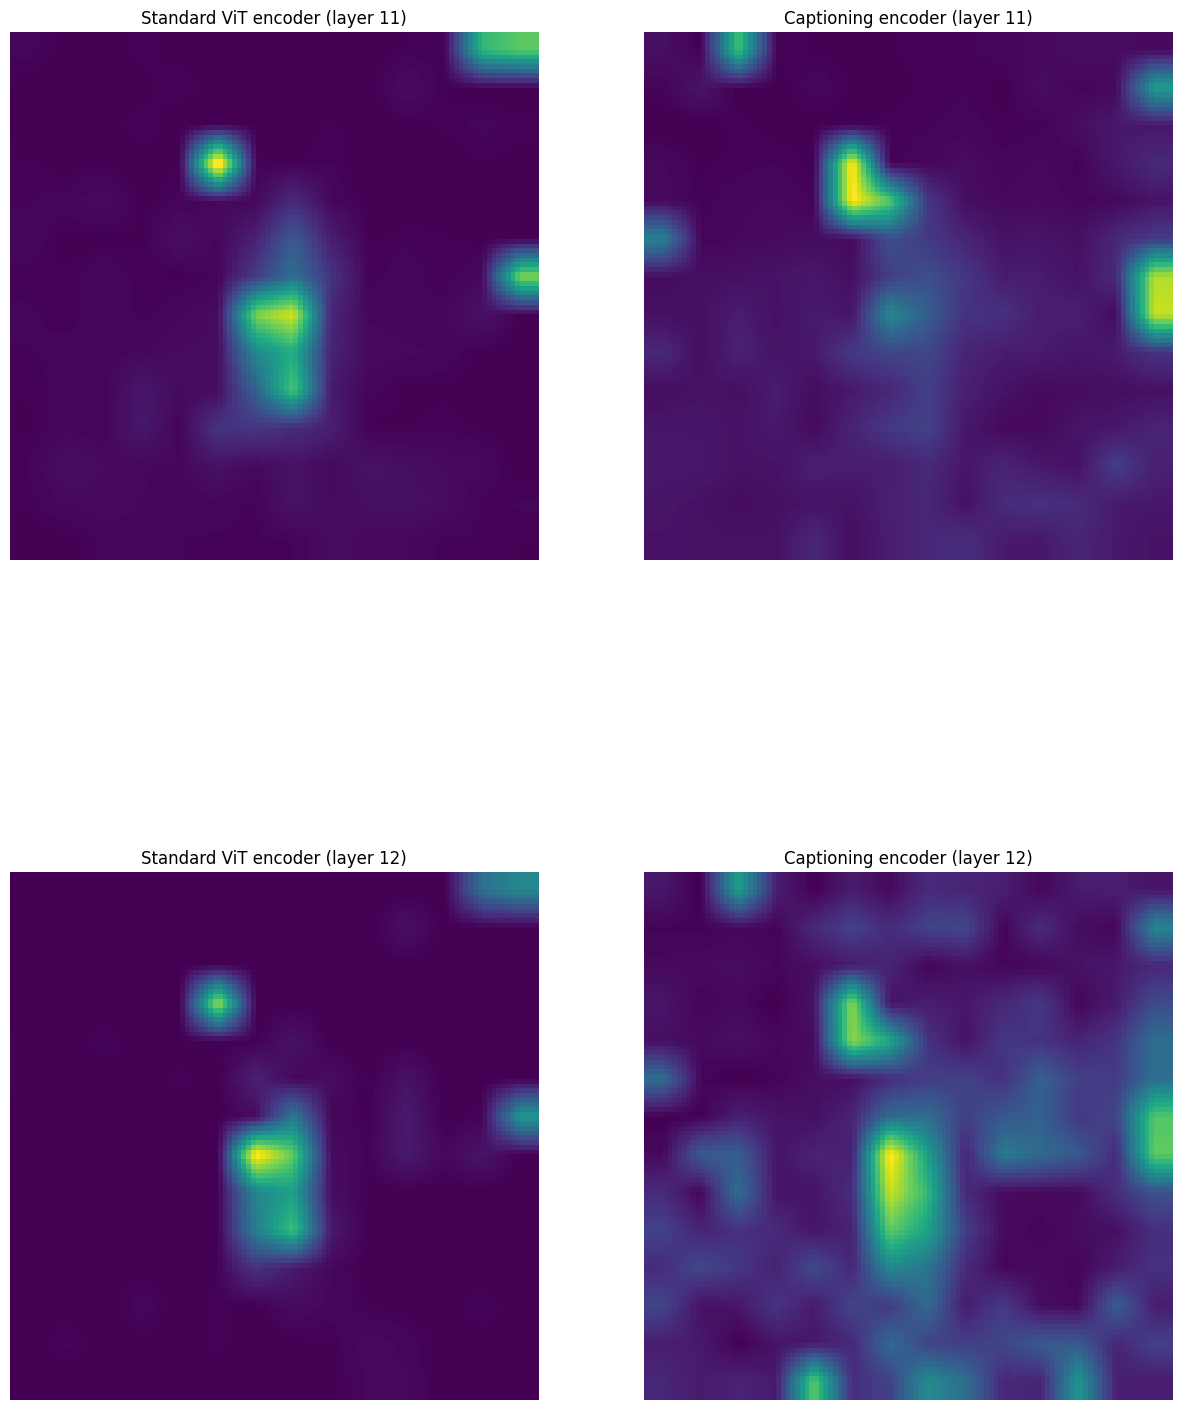

In [57]:
fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(15, 20))

for layer in range(2):
    axs[layer, 0].set_title(f'Standard ViT encoder (layer {11+layer})')
    axs[layer, 1].set_title(f'Captioning encoder (layer {11+layer})')
    axs[layer, 1].axis("off")
    axs[layer, 0].axis("off")
    axs[layer, 0].imshow(display_att_map(attention_maps[10+layer][0], img_size = (112,112)))
    axs[layer, 1].imshow(display_att_map(vit_attention_maps[10+layer][0], img_size = (112,112)))
plt.show()

In [58]:
from vit_captioning_analysis import order_obj_instances
from feature_extraction import get_bbox_center

In [59]:
vit_attention_maps.shape

torch.Size([12, 1, 197, 197])

In [60]:
vit_attention_maps[layer][0][0, 1:].shape

torch.Size([196])

In [61]:
vit_layer_att_map = vit_attention_maps[11][0][0, 1:].cpu().detach().numpy()
caption_layer_att_map = attention_maps[11][0][0, 1:].cpu().detach().numpy()
vit_layer_att_map.shape

(196,)

In [62]:
sample_img = Image.open(os.path.join(COCO_PATH, 'train2017', sample_ann['image']['file_name'])).convert('RGB')    

In [63]:
vit_ann_with_att = order_obj_instances(sample_img, image_annotations=copy.deepcopy(sample_ann), layer_attention_map=vit_layer_att_map)
cap_ann_with_att = order_obj_instances(sample_img, image_annotations=copy.deepcopy(sample_ann), layer_attention_map=caption_layer_att_map)

In [64]:
for ann in vit_ann_with_att:
#     ann[0]["label"] = f"{category_id_map[ann[0]['category_id']]} - {ann[1]}"
    ann[0]["att_score"] = copy.deepcopy(round(ann[1],2))
    ann[0]["label"] = f"{ann[0]['category_id']} - {str(ann[0]['att_score'])}"
vit_ann_with_att = [ann[0] for ann in vit_ann_with_att]

for ann in cap_ann_with_att:
#     ann[0]["label"] = f"{category_id_map[ann[0]['category_id']]} - {ann[1]}"
    ann[0]["att_score"] = copy.deepcopy(round(ann[1],2))
    ann[0]["label"] = f"{ann[0]['category_id']} - {str(ann[0]['att_score'])}"
    
cap_ann_with_att = [ann[0] for ann in cap_ann_with_att]  

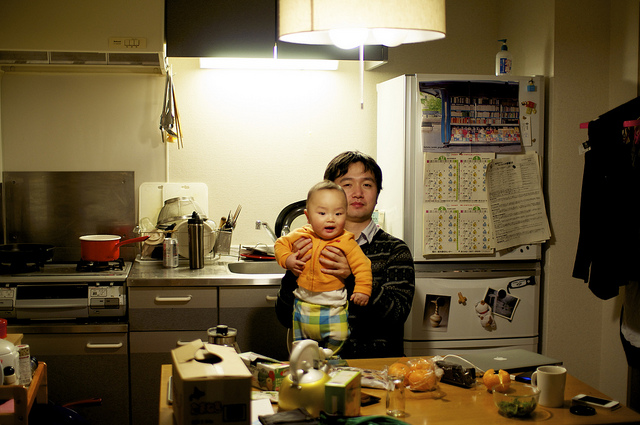

In [65]:
sample_img

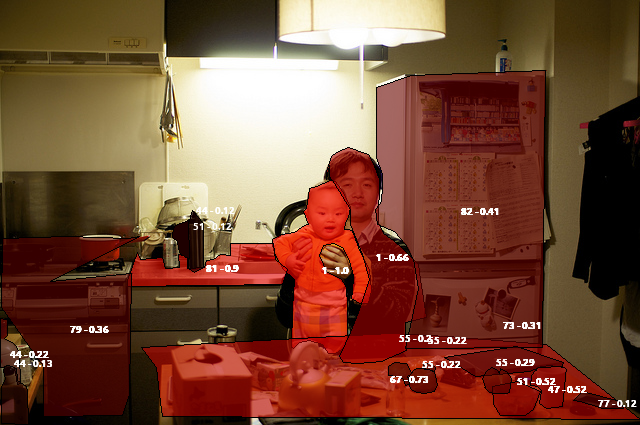

In [66]:
add_annotations(copy.deepcopy(sample_img), vit_ann_with_att)

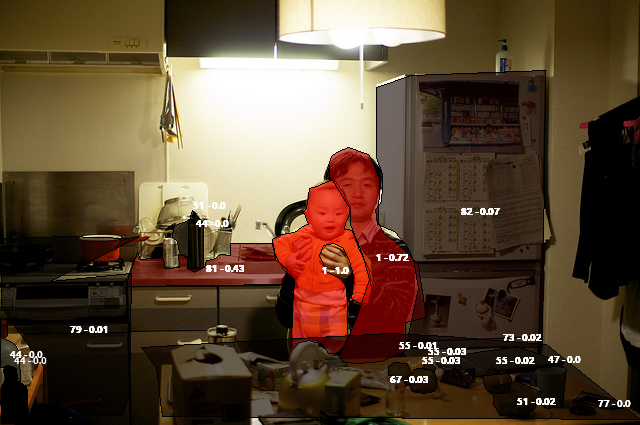

In [67]:
add_annotations(copy.deepcopy(sample_img), cap_ann_with_att)

### List of top attention objects

In [68]:
[{category_id_map[ann["category_id"]]: ann["att_score"]} for ann in vit_ann_with_att]

[{'person': 1.0},
 {'sink': 0.9},
 {'dining table': 0.73},
 {'person': 0.66},
 {'cup': 0.52},
 {'bowl': 0.52},
 {'refrigerator': 0.41},
 {'oven': 0.36},
 {'laptop': 0.31},
 {'orange': 0.29},
 {'bottle': 0.22},
 {'orange': 0.22},
 {'orange': 0.22},
 {'orange': 0.2},
 {'bottle': 0.13},
 {'cell phone': 0.12},
 {'bottle': 0.12},
 {'bowl': 0.12}]

In [69]:
[{category_id_map[ann["category_id"]]: ann["att_score"]} for ann in cap_ann_with_att]

[{'person': 1.0},
 {'person': 0.72},
 {'sink': 0.43},
 {'refrigerator': 0.07},
 {'dining table': 0.03},
 {'orange': 0.03},
 {'orange': 0.03},
 {'bowl': 0.02},
 {'orange': 0.02},
 {'laptop': 0.02},
 {'oven': 0.01},
 {'orange': 0.01},
 {'bottle': 0.0},
 {'bowl': 0.0},
 {'cup': 0.0},
 {'cell phone': 0.0},
 {'bottle': 0.0},
 {'bottle': 0.0}]